In [1]:
%matplotlib widget

In [2]:
import copy
import enum
import multiprocessing
import random
from collections import defaultdict
from dataclasses import dataclass
from itertools import product
from typing import Callable
from typing import Iterable
from typing import Mapping
from typing import Optional
from typing import Sequence
from typing import Tuple
from typing import TypeVar

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
import tqdm

In [3]:
# # doctest to catch regressions, copy below relevant code section
# import doctest
# doctest.testmod()

# Monte Carlo Methods

## <p style="color:red">Text content copied near verbatim from: <a href="http://incompleteideas.net/book/the-book-2nd.html">Sutton and Barto</a>. Code is my own unless otherwise stated.</p>

## Key Concepts

TODO

## Definitions

**Monte Carlo (MC) Methods**: 
- Generic definition: Repeated random sampling to obtain numerical results. 
- RL definition: A way of solving the RL problem based on averaging sample returns.

**Control Problem** (Reminder?): Approximate optimal policies (**through GPI?**).

**First-visit MC Method**:

**Every-visit MC Method**:

**Maintaining Exploration**: 

**Exploring Starts**:

**Monte Carlo ES**:

**On-policy methods**:

**Off-policy methods**:

**$\epsilon$-soft policy**: 

**Target Policy**:

**Behavior Policy**:

**Assumption of Coverage**:

**Importance Sampling**:

**Ordinary Importance Sampling**:

## Notation

TODO

## Introduction

Monte Carlo methods only require experience - sample sequences of states, actions, and rewards from actual or simulated interaction with an environment. They do _not_ require complete knowledge of the environment dynamics. 

For simulated learning a model is required but it only needs to generate sample transitions and not the complete probability distribution of all possible transitions. There are a surprising number of places where it is easy to generate experience sampled according to the desired probability distribution but infeasible to obtain the distributions in explicit form.

Monte Carlo methods solve the RL problem by averaging sample returns. Here we only consider Monte Carlo methods for episodic tasks. Only on completion of an episode are value estimates and policies changed. This means they can be used incrementally in an episode-by-episode nature but not in an online step-by-step way. 

In the previous notebook we looked at dynamic programming which _computed_ value functions from knowledge of the MDP. Monte Carlo methods here _learn_ value functions from sample returns with the MDP. The value functions and corresponding policies still interact to obtain optimality via general policy iteration. 

As per the previous chapter, we start by looking at the prediction problem, then the control problem and its solution by GPI. 

## 5.1: Monte Carlo Prediction

The "obvious" way to learn the state-value function - expected cumulative sum of future discounted reward - for a given policy is to average the returns observed after visits to a state. As more returns are observed, the average should converge to the expected value.

To estimate $v_\pi(s)$ we define:

- _visit_ to $s$: each occurrence of state $s$ in an episode
- _first visit_: the first time s is visited in an episode

This leads to the following MC methods:

- _first visit MC method_: estimates $v_\pi(s)$ as the average returns following first visits to $s$
- _every visit MC method_: averages returns following _all_ visits to $s$

These are similar but have different theoretical properties.

This chapter looks at first-visit MC. Every-visit MC extends more naturally to function approximation and eligibility tracing (ch 9/12).

In [4]:
StateT = TypeVar("StateT")
ActionT = TypeVar("ActionT")
RewardT = TypeVar("RewardT", int, float)

TraceT = Sequence[Tuple[StateT, ActionT, RewardT]]

In [5]:
def first_visit_mc(
    states: Sequence[StateT],
    episodes: Iterable[TraceT],
    gamma: float = 0.9
) -> Mapping[StateT, RewardT]:
    """
    
    Example:
        >>> def gen_ep(n_episodes):
        ...     for _ in range(n_episodes):
        ...         yield [(0, 0, 0.5), (0, 0, 0.75), (1, 0, 1.0), (0, 0, 0.75)]
        >>> value_map = first_visit_mc(states=[0, 1], episodes=gen_ep(1), gamma=0.5)
        >>> value_map[0] == 1.21875
        True
        >>> value_map[1] == 1.375
        True
    """
    visits = defaultdict(int)
    values = dict((s, 0.0) for s in states)
    
    for trace in tqdm.tqdm(episodes):
        ret = 0.0
        fv = first_visits(trace)
        for first_visit, (state, _, reward) in reversed(list(zip(fv, trace))):
            ret = reward + gamma*ret
            
            if first_visit:
                visits[state] += 1
                values[state] += (1.0 / visits[state]) * (ret - values[state])
                
    return values


def first_visits(trace: TraceT, state_action_pairs: bool = False) -> Sequence[bool]:
    """
    
    Example:
    
        >>> first_visits([(0, 0, 0.5)])
        [True]
        >>> first_visits([(0, 0, 0.5), (1, 0, 0.1), (0, 0, 0.5)])
        [True, True, False]
    """
    visited = set()
    fv = []
    for s, a, _ in trace:
        if state_action_pairs:
            fv.append((s, a) not in visited)
            visited.add((s, a))
        else:
            fv.append(s not in visited)
            visited.add(s)
        
    return fv

Note that a list containing the returns for each first-visit could be stored for each state, similar to how a list of rewards were stored when computing bandit problems.

The above implementation avoids this by using the same trick employed in the bandit notebook: it derives an update equation.

Recall that to compute the $k + 1$th estimate of $q$ in update-equation form where $G_i$ is the return received during the $i$th first visit to state-action $(s, a)$:

\begin{align}
q_{k + 1}(s, a) &= \frac{1}{n} \sum_{i=1}^{n} G_i \\
                &= \frac{1}{n} \left[G_{n} + \sum_{i=1}^{n - 1} G_k \right] \\
                &= \frac{1}{n} \left[G_{n} + (n - 1) \frac{1}{n-1}\sum_{i=1}^{n-1} G_k \right] \\
                &= \frac{1}{n} \left[G_{n} + (n - 1) q_k(s, a) \right] \\
                &= \frac{1}{n} \left[G_{n} + n q_k(s, a) - q_k(s, a) \right] \\
                &= q_k(s, a) + \frac{1}{n} \left[G_{n} - q_k(s, a) \right] \\
\end{align}

---

Both first-visit MC and every-visit MC converge to $v_\pi(s)$ as the number of visits (or first visits) to $s$ goes to infinity.

In [6]:
# Example 5.1: Blackjack 

In [7]:
class BJAction(enum.IntEnum):
    STICK = 0
    HIT = 1
    
    
class BJCard(enum.IntEnum):
    ACE   = 11
    TWO   = 2
    THREE = 3
    FOUR  = 4
    FIVE  = 5
    SIX   = 6
    SEVEN = 7
    EIGHT = 8
    NINE  = 9
    TEN   = 10
    
    @staticmethod
    def _prob(card) -> float:
        if card == BJCard.TEN:
            return 4.0 / 13
        return 1.0 / 13

    @staticmethod
    def hit(n_cards=None):
        return np.random.choice(BJCard, size=n_cards, p=[BJCard._prob(c) for c in BJCard]).tolist()

    
@dataclass
class Hand:
    value: int
    usable_ace: bool
        
    def __init__(self, cards):
        self.value = 0
        self.usable_ace = False
        for card in cards:
            if card != BJCard.ACE:
                self.value += card
            else:
                if self.usable_ace:
                    # cannot have more than one usable ace (11 + 11 > 21)
                    self.value += 1
                else:
                    # attempt to use max value, correct later if > 21
                    self.value += 11
                    self.usable_ace = True

            if self.value > 21:
                if self.usable_ace:
                    self.value -= 10
                    self.usable_ace = False
                else:
                    self.value = 22
        
    def add(self, card):
        self.value += card
        if self.value > 21:
            if self.usable_ace:
                self.value -= 10
                self.usable_ace = False
            else:
                self.value = 22      
        return self
    
    def __hash__(self):
        return hash(self.value) + hash(self.usable_ace)

    
@dataclass
class BJState:
    player: Hand
    dealer: Hand
        
    @staticmethod
    def new(exploring_starts: bool = False):
        if not exploring_starts:
            # sample from typical game setup
            cards = BJCard.hit(3)
            player = Hand(cards[:2])
            dealer = Hand(cards[2:])
        else:
            # sample uniform random of all possible states
            player = Hand([])
            player.value = np.random.randint(4, 21 + 1)
            player.usable_ace = np.random.choice([False, True])
            dealer = Hand([])
            dealer.value = np.random.randint(2, 11 + 1)
            dealer.usable_ace = dealer.value == 11
        
        return BJState(player, dealer)
        
    
    def copy(self):
        return copy.deepcopy(self)
    
    def __hash__(self):
        return hash(self.player) + hash(self.dealer)

In [8]:
def bj_states() -> Sequence[BJState]:
    states = []
    for player_value in range(4, 21 + 1):
        for usable_ace in [False, True]:
            for dealer_value in range(2, 11 + 1):
                player = Hand([])
                player.value = player_value
                player.usable_ace = usable_ace

                dealer = Hand([])
                dealer.value = dealer_value
                dealer.usable_ace = dealer_value == 11

                states.append(BJState(player, dealer))
    return states


def bj_state_actions() -> Mapping[BJState, Sequence[BJAction]]:
    state_actions = {}
    for state in bj_states():
        state_actions[state] = []
        for action in BJAction:
            state_actions[state].append(action)
    return state_actions

In [9]:
class Stick_20_21:
    def __getitem__(self, state_action: Tuple[BJState, BJAction]) -> float:
        state, action = state_action
        if state.player.value in {20, 21}:
            if action == BJAction.STICK:
                return 1.0
            return 0.0
        if action == BJAction.HIT:
            return 1.0
        return 0.0

In [10]:
def bj_simulate(
    policy: Mapping[Tuple[BJState, BJAction], float],
    exploring_starts: bool = False
) -> Sequence[Tuple[BJState, BJAction, int]]:
    """..."""
    states = []
    actions = []
    rewards = []
    
    state = BJState.new(exploring_starts)
    
    # simulate player until sticks or goes bust
    first_action = True
    while True:
        if state.player.value > 21:
            break
            
        states.append(state.copy())
        
        if exploring_starts and first_action:
            action_probs = None
        else:
            action_probs = [policy[(state, a)] for a in BJAction]
        action = np.random.choice(BJAction, p=action_probs)
        first_action = False
        actions.append(action)

        if action == BJAction.HIT:
            state.player.add(BJCard.hit())
            if state.player.value > 21:
                break
            rewards.append(0)
        elif action == BJAction.STICK:
            break
    
    # compute final reward
    if state.player.value > 21:
        # player bust
        reward = -1
    else:
        # player not bust, compute dealer value using fixed policy
        while state.dealer.value < 17:
            state.dealer.add(BJCard.hit())
        if state.dealer.value > 21:
            # dealer bust
            reward = 1
        else:
            if state.player.value == state.dealer.value:
                reward = 0
            elif state.player.value > state.dealer.value:
                reward = 1
            else:
                reward = -1
        
    rewards.append(reward)

    assert len(states) == len(actions) == len(rewards)

    return list(zip(states, actions, rewards))

In [11]:
def generate(f, q_in, q_out, seed):
    # force different seed per process to avoid 
    # processes simulating the same episodes
    np.random.seed(seed)
    random.seed(seed)
    to_gen = q_in.get()
    for _ in range(to_gen):
        q_out.put(f())
        

def bj_simulate_n(policy, n_episodes, n_procs=10):
    assert n_procs > 0
    if n_procs == 1:
        for _ in range(n_episodes):
            yield bj_simulate(policy)
        return
        
    q_in = multiprocessing.Queue()
    q_out = multiprocessing.Queue()

    proc = [
        multiprocessing.Process(
            target=generate, 
            args=(lambda: bj_simulate(policy), q_in, q_out, seed)
        )
        for seed in range(n_procs)
    ]
    
    for p in proc:
        p.daemon = True
        p.start()
        
    for pid in range(n_procs):
        to_proc = n_episodes // n_procs
        if pid == n_procs - 1:
            to_proc += n_episodes % n_procs
        q_in.put(to_proc)

    for _ in range(n_episodes):
        yield q_out.get()

    [p.join() for p in proc]

In [12]:
def run(n_procs, n_episodes):
    state_values = first_visit_mc(
        states=bj_states(),
        episodes=bj_simulate_n(Stick_20_21(), n_episodes, n_procs=n_procs),
        gamma=1.0
    )
    return state_values

In [369]:
state_values = {}
for n_episodes in [10000, 500000]:
    state_values[n_episodes] = run(n_procs=6, n_episodes=n_episodes)

10000it [00:01, 5807.82it/s]
500000it [01:31, 5452.21it/s] 


In [370]:
plt.close("all")
fig = plt.figure(figsize=(10, 8))

for i, n_episodes in enumerate(sorted(state_values.keys())):
    for j, usable_ace in enumerate([True, False]):
        values = np.empty((10, 10))

        for state, value in state_values[n_episodes].items():
            if state.player.usable_ace != usable_ace:
                continue
            values[ state.player.value - 12, state.dealer.value - 2] = value

        X, Y = np.meshgrid(range(2, 11 + 1), range(12, 21 + 1))
        xs = X.flatten()
        ys = Y.flatten()
        zs = values.flatten()

        ax = fig.add_subplot(2, 2, i + j*2 + 1, projection="3d")
        surf = ax.plot_trisurf(xs, ys, zs)
        ax.set_zlim3d(-1, 1)
        
        ax.set_xlabel("Dealer showing")
        ax.set_ylabel("Player sum")

fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

---

Exercise 5.1: The value function jumps up for the last two rows as the policy is to stick at a value of 20 or 21 and the probability of the player winning when in either of these states is high. It drops off for the far right row (left in the book's figures) as the dealer has an ace (valued 11). An ace combined with a 10 means the player cannot and the probability of drawing a card with a value of 10 is relatively high (16/52). The frontmost values are higher when there is a usable ace as the player has less of a chance of going bust - if the player draws a high card to go bust in the lower diagrams they lose but in the upper diagrams the ace takes the value of 1 rather than 10 allowing the player to continue.

Exercise 5.2: The results will be identical as no state is visited twice in an episode of black jack (assuming "usable ace" is part of the state).

---

#### Backup Diagrams for MC Methods

The general idea of backup diagrams is to show at the top the root node to be updated and to show below all the transitions and leaf nodes whose rewards and estimated values contribute to the update. 

For MC estimation of $v_\pi$ the root node is a state node and below is the trace for a single episode. 

This is in contrast to DP algorithms that include only one-step transitions.

Another difference is that for MC methods the estimate of each state is independent - one estimate does not build upon another estimate. MC methods do not bootstrap.

Estimation of a state's value using MC methods is therefore independent of all other states. This allows only the state space of interest to be explored (which may be significantly smaller than the entire space). 

### Monte Carlo Estimation of Action Values

If a model is not available then it is useful to estimate _action_ values rather than _state_ values.

With a model all that is required are state values as you can look ahead to find which actions lead to the best reward and next states. 

Without a model you are unable to see the distribution of rewards and next states given an action meaning the action-value function is required.

To best exploit Monte Carlo methods - which do not need to know the dynamics (model) - we will look at estimating the optimal action value function $q_*$. 

---

Recall the policy evaluation problem for action values: estimate $q_\pi(s, a)$ (the expected return when in state $s$ taking action $a$ and thereafter following policy $\pi$). 

The method will essentially be the same as in the previous section but now recording state-action pairs. A state-action pair is visited in an episode if the action $a$ is taken in state $s$. 

- _every visit MC method_ for action-values: estimates by averaging all returns that have followed visits to it.
- _first visit MC method_ for action-values: estimates by averaging all returns that have followed from first visits to it. 

These methods **converge quadratically to the true expected values as the number of visits to each state-action pair approaches infinity**.

---

Problem: many state-action pairs will never be visited.

If $\pi$ is a deterministic policy, then returns will only be observed for one action for each state. This means all other action values will not improve with experience. The use of policy evaluation is for control and hence it is important to learn action values! 

Solution: we need to estimate the value of _all_ actions from each state, not just the one we currently favor.

This is the general problem of _maintaining exploration_. For policy evaluation to work for action values, we must assure continual exploration. 

More concrete solutions:

1. *Exploring starts*: Specify that the episodes start in a state-action pair and guarantee that every pair has a nonzero probability of being selected as the start.
2. Consider only policies that are stochastic with a nonzero probability of selecting all actions in each state. 

For now the sections assume exploring starts.

### Monte Carlo Control

To approximate optimal policies we proceed as in the previous chapter on DPs: use generalized policy iteration (GPI).

Recall that in GPI you maintain an approximate policy and approximate value function. The value function is repeatedly altered to more closely approximate the value function for the current policy, and the policy is repeatedly improved with respect to the current value function. 

These two changes appear to work against each other but together they cause the policy and value function to approach optimality (policy improvement theorem).

Assuming an infinite number of episodes are observed using exploring starts the Monte Carlo policy evaluation methods will compute each $q_{\pi_k}$ for the policy $\pi_k$. 

Policy improvement is done by making the policy greedy with respect to the current value function:

\begin{align}
    \pi(s) \doteq \arg \max_a q(s, a)
\end{align}

Policy improvement theorem applies to $\pi_k$ and $\pi_{k + 1}$ because, for all $s \in S$:

\begin{align}
    q_{\pi_k}(s, \pi_{k + 1}(s)) &= q_{\pi_k}(s, \arg \max_a q_{\pi_k}(s, a)) \\
                                 &= \max_a q_{\pi_k}(s, {\pi_k}(s, a)) \\
                                 &\geq q_{\pi_k}(s, \pi_k(s)) \\
                                 &\geq v_k(s)
\end{align}

This shows that each $\pi_{k + 1}$ is uniformly better than $\pi_k$ or just as good in which case they are both optimal policies. 

---

The above shows that Monte Carlo methods can be used to find optimal policies given only sample episodes and no other knowledge of the environment's dynamics.

Two assumptions were made in order to obtain this guarantee of convergence:

1. Episodes have exploring starts.
2. Policy evaluation could be done with an infinite number of episodes.

To obtain a practically useful algorithm both assumptions need to be removed.

---

Removing assumption 2: policy evaluation is done with an infinite number of episodes.

The first approach is to make measurements and assumptions and bound the on the magnitude and probability of error and then to ensure sufficient steps are taken each iteration to make sure they are small. This is likely to require too many episodes to be useful in practice. 

A second approach is to avoid the infinite number of episodes required for policy evaluation. As in the previous chapter when using value iteration or in-place value iteration that alternates single steps of policy evaluation and policy improvement for each state.

The second approach is taken for Monte Carlo: policy iteration switches between policy evaluation and policy improvement on an episode-by-episode basis. This algorithm is called **Monte Carlo ES** where ES means exploring starts.

Note that this is very similar to `first_visit_mc` but it now includes a policy iteration step and state-action pairs rather than just states.

In [13]:
def monte_carlo_es(
    state_actions: Mapping[StateT, Sequence[ActionT]],
    gen_episode: Callable[[Mapping[Tuple[StateT, ActionT], float]], TraceT],
    n_episode: int,
    gamma: float = 0.9,
    policy: Optional[Mapping[Tuple[StateT, ActionT], float]] = None
) -> Tuple[Mapping[StateT, RewardT], Mapping[Tuple[StateT, ActionT], float]]:
    """
    
    """
    if policy is None:
        policy = random_policy(state_actions)
    
    visits = defaultdict(int)
    action_values = {}
    for state, actions in state_actions.items():
        action_values[state] = {}
        for action in actions:
            action_values[state][action] = 0.0
    
    for _ in tqdm.trange(n_episode):
        trace = gen_episode(policy)
        ret = 0.0
        fv = first_visits(trace, state_action_pairs=True)
        for first_visit, (state, action, reward) in reversed(list(zip(fv, trace))):
            ret = reward + gamma*ret
            
            if first_visit:
                visits[(state, action)] += 1
                action_values[state][action] += (
                    (1.0 / visits[(state, action)]) * (ret - action_values[state][action])
                )
                update_policy_(state, action_values, policy)
                
    return action_values, policy, visits


def random_policy(
    state_actions: Mapping[StateT, Sequence[ActionT]],
    deterministic: bool = False
) -> Mapping[Tuple[StateT, ActionT], float]:
    """

    """
    policy = {}
    
    for state, actions in state_actions.items():
        for action in actions:
            policy[(state, action)] = 0.0 if deterministic else 1.0 / len(actions)
        if deterministic:
            policy[(state, random.choice(actions))] = 1.0
        
    return policy


def update_policy_(
    state: StateT, 
    action_values: Mapping[StateT, Mapping[ActionT, float]],
    policy: Mapping[Tuple[StateT, ActionT], float]
) -> None:
    """
    
    Example:
        >>> p = {(1, "a"): 0.0, (1, "b"): 1.0}
        >>> update_policy_(
        ...     state=1,
        ...     action_values={1: {"a": 100.0, "b": 5.0}},
        ...     policy=p
        ... )
        >>> p
        {(1, 'a'): 1.0, (1, 'b'): 0.0}
    """
    best_action = None
    best_value = -float("inf")
    
    for action, value in action_values[state].items():
        if best_action is None or value > best_value:
            best_value = value
            best_action = action
        policy[(state, action)] = 0.0
    policy[(state, best_action)] = 1.0   

In [493]:
action_values, policy, visits = monte_carlo_es(
    state_actions=bj_state_actions(),
    gen_episode=lambda p: bj_simulate(p, exploring_starts=True),
    n_episode=int(10e6),
    gamma=1.0
)

100%|██████████| 10000000/10000000 [1:11:58<00:00, 2315.60it/s]


In [14]:
from matplotlib.patches import Patch

In [15]:
%matplotlib inline
img = np.ones((22, 12)) * -1
probs = np.zeros((22, 12))

usable_ace = False

for (state, action), prob in policy.items():
    if state.player.usable_ace != usable_ace:
        continue
    if prob < probs[state.player.value, state.dealer.value]:
        continue
    probs[state.player.value, state.dealer.value] = prob
    img[state.player.value, state.dealer.value] = int(action)

# rotate ace to have low rather than high value to match book
ace = img[:, -1]
img[:, 1:] = img[:, :-1]
img[:, 3] = ace

# plot image and clip to match book
plt.imshow(img, origin="lower")
plt.xlim(2.5)
plt.ylim(3.5)

# create legend with colors for each action
legend_elements = [
    Patch(facecolor=pos.cmap.colors[len(pos.cmap.colors) // 2], label=BJAction(0)),
    Patch(facecolor=pos.cmap.colors[-1], label=BJAction(1))
]
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), handles=legend_elements)

plt.show()

NameError: name 'policy' is not defined

In [16]:
def recover_state_values(
    policy: Mapping[Tuple[StateT, ActionT], float],
    action_values: Mapping[StateT, Mapping[ActionT, float]],
) -> Mapping[StateT, float]:
    state_values = {}
    for state, act_vals in action_values.items():
        state_values[state] = 0
        for act, val in act_vals.items():
            state_values[state] += policy[(state, act)] * val
    return state_values

In [569]:
state_values = recover_state_values(policy, action_values)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

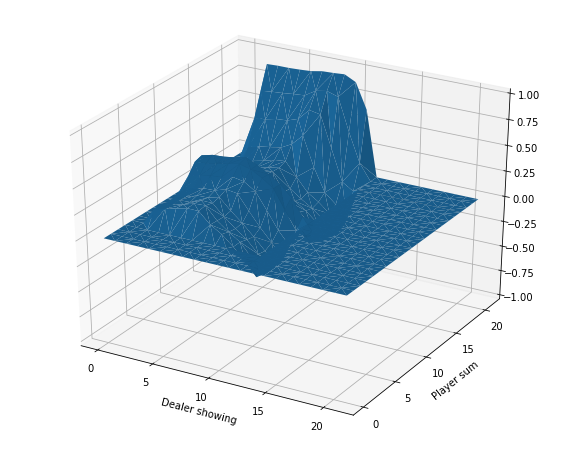

In [570]:
plt.close("all")
%matplotlib widget
fig = plt.figure(figsize=(10, 8))

usable_ace = True 
values = np.zeros((22, 22))
    
for state, value in state_values.items():
    if state.player.usable_ace != usable_ace:
        continue
    values[state.player.value, state.dealer.value] = value

X, Y = np.meshgrid(range(0, 22), range(0, 22))
xs = X.flatten()
ys = Y.flatten()
zs = values.flatten()

ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_trisurf(xs, ys, zs)
ax.set_zlim3d(-1, 1)

ax.set_xlabel("Dealer showing")
ax.set_ylabel("Player sum")
    
plt.show()

### 5.4 Monte Carlo Control without Exploring Starts

The only way for actions to be selected infinitely is for the agent to continue to select them. 

There are two approaches to ensuring this:

1. *On-policy* methods: Evaluate or improve the policy that is used to make decisions.
2. *Off-policy* methods: Evaluate or improve a policy that is different from that used to generate the data.

The Monte Carlo ES method above is an on-policy method. This section explores an on-policy method that does not need the unrealistic assumption of exploring starts.

#### On-policy Control Methods

In general these methods make the policy *soft*, meaning that $\pi(a | s) > 0$ for all $s \in \mathcal{S}$ and all $a \in \mathcal{A}(s)$, but it is gradually shifted closer to a deterministic optimal policy. 

One such technique is $\epsilon$-greedy policies. Recall that all nongreedy actions are given the minimal probability of selection $\frac{\epsilon}{|\mathcal{A}(s)|}$ and the remaining probability mass $1 - \epsilon + \frac{\epsilon}{|\mathcal{A}(s)|}$ is given to the greedy action. 

$\epsilon$-greedy policies are examples of $\epsilon$-soft policies: $\pi(a | s) \geq\frac{\epsilon}{|\mathcal{A}(s)|}$ for all states and actions for some $\epsilon > 0$.  

--- 

On-policy Monte Carlo Control still follows GPI. When replacing ES we can nolonger make the policy greedy with respect to the value function as this prevents exploration of the nongreedy actions. This is okay as GPI only requires the policy be moved towards the greedy policy and not be the greedy policy itself. 

The new on-policy method will move it towards an $\epsilon$-greedy policy. For any $\epsilon$-soft policy, $\pi$, any $\epsilon$-greedy policy with respect to $q_\pi$ is guaranteed to be better than or equal to $\pi$. 

The policy improvement theorem assures that the $\epsilon$-greedy policy with respect to $q_\pi$ is an improvement over any $\epsilon$-soft policy.

Let $\pi'$ be the $\epsilon$-greedy policy and $\pi$ be any other $\epsilon$-soft policy:

\begin{align}
    q_\pi(s, \pi'(s)) &= \sum_a \pi'(a | s)q_\pi(s, a) \\
                      &= \frac{\epsilon}{|\mathcal{A}(s)|} \sum_a q_\pi(s, a) + (1 - \epsilon) \max_a q_\pi(s, a) \\
                      &\geq \frac{\epsilon}{|\mathcal{A}(s)|} \sum_a q_\pi(s, a) + (1 - \epsilon) \sum_a \frac{\pi(a | s) - \frac{\epsilon}{|\mathcal{A}(s)|}}{1 - \epsilon} q_\pi(s, a) \\
                      &= \frac{\epsilon}{|\mathcal{A}(s)|} \sum_a q_\pi(s, a) - \frac{\epsilon}{|\mathcal{A}(s)|} \sum_a q_\pi(s, a) + \sum_a \pi(a|s)q_\pi(s, a) \\
                      &= \sum_a \pi(a|s)q_\pi(s, a) \\
                      &= v_\pi(s)
\end{align}

Simplifying one step in the above:

\begin{align}
    \frac{\epsilon}{|\mathcal{A}(s)|} \sum_a q_\pi(s, a) + (1 - \epsilon) \max_a q_\pi(s, a) \geq \frac{\epsilon}{|\mathcal{A}(s)|} \sum_a q_\pi(s, a) + (1 - \epsilon) \sum_a \frac{\pi(a | s) - \frac{\epsilon}{|\mathcal{A}(s)|}}{1 - \epsilon} q_\pi(s, a) \\
    \max_a q_\pi(s, a) \geq \sum_a \frac{\pi(a | s) - \frac{\epsilon}{|\mathcal{A}(s)|}}{1 - \epsilon} q_\pi(s, a)
\end{align}

We see that the max action-value is greater than or equal to a weighted sum of all possible action-values. Recall that the action-value function is $\epsilon$-soft so it's guaranteed that $\pi(a | s) \geq \frac{\epsilon}{|\mathcal{A}(s)|}$. Therefore $\pi(a | s) - \frac{\epsilon}{|\mathcal{A}(s)|}\geq 0$.

Summing over this we see that this has $1 - \epsilon$ total probability mass:

\begin{align}
    \sum_a \pi(a | s) - \frac{\epsilon}{|\mathcal{A}(s)|} &= \sum_a \pi(a | s) - \sum_a \frac{\epsilon}{|\mathcal{A}(s)|} \\
                                                         &= 1 - \epsilon \\
\end{align}

Therefore to make the weighted sum a weighted average each part inside the sum, $\frac{\pi(a | s) - \frac{\epsilon}{|\mathcal{A}(s)|}}{1 - \epsilon}$, must include $1 - \epsilon$ in the denominator so the probability mass sums to one.

From the above we see $\pi' \geq \pi$ as $v_\pi'(s) \geq v_\pi(s)$ for all $s \in \mathcal{S}$.

### Off-policy Prediction via Importance Sampling

How can learning control methods learn about the optimal policy whilst behaving according to an exploratory policy?

A different approach to that above is to use two policies:

1. *Target policy*: Policy being learned.
2. *Behavior policy*: Policy used to generate behavior.

The data generated by the behavior policy is _off_ the target policy and the general process is known as _off-policy learning_.

Off-policy methods are typically of greater variance and slower to converge but are more powerful and general. e.g. they can use data generated by a non-learning controller or a human expert. 

On-policy methods are a subset of off-policy methods where the target policy and behavior policy and the same. 

#### Prediction Problem

Start by looking at policy evaluation when the target and behavior policies are fixed. That is, we wish to evaluate $v_\pi$ or $q_\pi$ when all the episodes are following another policy $b$ (behavior policy) where $b \neq \pi$. 

*Assumption of coverage*: Policy $b$ must take all actions that can be taken by policy $\pi$. i.e. $\pi(a | s) > 0 \implies b(a | s) > 0$ to ensure convergence. 

Given the assumption of coverage, $b$ must be stochastic when it is in states not identical to $\pi$. The target policy $\pi$ may be deterministic. 

Typically the target policy is the deterministic greedy policy while the behavior policy remains stochastic and more exploratory (e.g. $\epsilon$-greedy). 

*Importance sampling*: A general technique for estimating expected values under one distribution given samples from another. 

---

General importance sampling overview: Given two discrete distributions $f$ and $g$ that you can evaluate then the expected value of $g$ can be computed by sampling from $f$ as follows:

\begin{align}
    \mathbb{E}_g\left[X\right] &= \sum_x x g(x) \\
                     &= \sum_x x \frac{g(x)}{f(x)}f(x) \\
                     &= \mathbb{E}_f \left[x \frac{g(x)}{f(x)} \right]
\end{align}

i.e. you can compute the expected value of $g$ when only sampling from $f$ provided you can compute the ratio - "weight" - between the two. 

---

In this case importance sampling will be applied to off-policy learning by reweighting returns according to the relative probability of their trajectories occurring under the target and behavior policies, called *importance-sampling ratio*.

Given a starting state $S_t$, the probability of the subsequent state-action trajectory $A_t, S_{t + 1}, A_{t + 1}, ..., S_T$ occurring under any policy $\pi$ is:

\begin{align}
    Pr\{S_{t + 1}, A_{t + 1}, ..., S_T | S_t, A_{t:T-1} \sim \pi\} &= \pi(A_t | S_t)p(S_{t+1} | S_t, A_t) \pi(A_{t+1}|S_{t+1})...p(S_T | S_{T-1}, A_{T-1}) \\
        &= \prod_{k=t}^{T-1}\pi(A_k | S_k) p(S_{k+1}|S_k, A_k)
\end{align}

The importance sampling ratio is therefore:

\begin{align}
p_{t:T-1} &\doteq \frac{\prod_{k=t}^{T-1}\pi(A_k | S_k) p(S_{k+1}|S_k, A_k)}{\prod_{k=t}^{T-1}b(A_k | S_k) p(S_{k+1}|S_k, A_k)}  \\
          &= \prod_{k=t}^{T-1}\frac{\pi(A_k | S_k)}{b(A_k | S_k)}
\end{align}

The trajectory probabilities depend on the MDP's probabilities, and these are generally unknown. However, because they appear in both the numerator and denominator they cancel and the importance sampling ratio only ends up depending on the two policies and not on the MDP.

To estimate the expected returns under the target policy we use this weighting and returns from the behavior policy $\mathbb{E}[G_t|S_t = s] = v_b(s)$:

\begin{equation}
    \mathbb{E}[p_{t:T-1} G_t | S_t = s] = v_\pi(s)
\end{equation}

---

Now to give a Monte Carlo algorithm that averages returns from a _batch_ of observed episodes following policy $b$ to estimate $v_\pi(s)$. 

The first convenience is to have time step numberings continue sequentially across episode boundaries. 

Let:

- $\mathcal{T}(s)$: the set of all time steps in which state $s$ is visited (every-visit; for first-visit $\mathcal{T}(s)$ would only include time steps that were first visits of $s$ within their episode). 
- $T(t)$: the first time of termination following time $t$.
- $G_t$ denote the return after $t$ to $T(t)$.

Then $\{G_t\}_{t\in\mathcal{T}(s)}$ are the returns that pertain to state $s$ and $\{p_{t:T(t) - 1}\}_{t\in\mathcal{T}(s)}$ are the importance sampling ratios. 

To estimate $v_\pi(s)$ we scale the returns by the ratios and average the results:

\begin{equation}
V(s) \doteq \frac{ \sum_{t \in \mathcal{T}(s)} p_{t:T(t) - 1} G_t}{|\mathcal{T}(s)|}
\end{equation}

This is *ordinary importance sampling*. 

*Weighted importance sampling* uses a *weighted* average:

\begin{equation}
V(s) \doteq \frac{ \sum_{t \in \mathcal{T}(s)} p_{t:T(t) - 1} G_t}{p_{t:T(t) - 1}}
\end{equation}

Ordinary importance sampling is unbiased whereas weighted is biased (bias converges to 0). 

Ordinary importance sampling has unbounded variance because the importance ratio is unbounded whereas the weighted importance sampling variance is must lower (variance any single return is one, converges to zero if bounded returns). 

See: https://papers.nips.cc/paper/5249-weighted-importance-sampling-for-off-policy-learning-with-linear-function-approximation.pdf

Every-visit methods for both methods are biased but this goes to zero as the number of samples increases. Every-visit methods are often preferred because they remove the need to keep track of which states have been visited and they are easier to extend to function approximation. 

---

Exercise 5.5

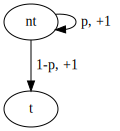

In [17]:
import graphviz

g = graphviz.Digraph(graph_attr={"rankdir": "TB"})
g.node("nt")
g.node("t")

g.edge("nt", "nt", label="p, +1")
g.edge("nt", "t",  label="1-p, +1")

g

In [18]:
rewards = [1] * 10

For 10 step episode, first-visit reward is estimated as the average of returns after each first visit. Here there is only one visit. The return after the first visit is 10, see below, therefore the estimate is 10. For every-visit the estimate is $\frac{1}{10} \sum_{i=1}^{10} i = 5.5$.

In [19]:
g_t = 0
gamma = 1
for i, r in enumerate(reversed(rewards)):
    g_t = r + gamma * g_t
    print(f"Step {len(rewards) - i:2d}: {g_t}")

Step 10: 1
Step  9: 2
Step  8: 3
Step  7: 4
Step  6: 5
Step  5: 6
Step  4: 7
Step  3: 8
Step  2: 9
Step  1: 10


---

Exercise 5.6: What is the equation analogous to the one below for _action_ values $Q(s, a)$ instead of state values $V(s)$, again given returns generated using $b$?

\begin{equation}
V(s) \doteq \frac{ \sum_{t \in \mathcal{T}(s) } p_{t : T(t) - 1} G_t }
                 { \sum_{t \in \mathcal{T}(s) } p_{t : T(t) - 1} }
\end{equation}

Answer: Previously we defined the probability of the state-action trajectory starting from $s$. Now we need that starting at $(s, a)$:

\begin{align}
    Pr'\{ &S_{t + 1}, A_{t + 1}, \dots, S_T | S_t, A_t, A_{t + 1 : T - 1} \sim \pi \} \\
        &= p(S_{t + 1} | S_t, A_t) \pi(A_{t + 1} | S_{t + 1}) \dots p(S_T | S_{T - 1} A_{T - 1}) \\
        &= p(S_{t + 1} | S_t, A_t) \prod_{k = t + 1}^{T - 1} \pi(A_k | S_k) p(S_{k + 1} | A_k, S_k)
\end{align}

Updating the relative probability:

\begin{align}
    \rho'_{t: T-1} &\doteq 
    \frac{ 
        p(S_{t + 1} | S_t, A_t) \prod_{k = t + 1}^{T - 1} \pi(A_k | S_k) p(S_{k + 1} | A_k, S_k)  }
      { p(S_{t + 1} | S_t, A_t) \prod_{k = t + 1}^{T - 1}   b(A_k | S_k) p(S_{k + 1} | A_k, S_k) 
    } \\
    &= \frac{ 
        \prod_{k = t + 1}^{T - 1} \pi(A_k | S_k) p(S_{k + 1} | A_k, S_k)  }
      { \prod_{k = t + 1}^{T - 1}   b(A_k | S_k) p(S_{k + 1} | A_k, S_k) 
    } \\
    &= \rho_{t + 1:T-1}
\end{align}

Intuitively this makes sense as for action-values the first action probability is now 1 as the action is specified and the two policies share the same environment dynamics and hence that cancels when computing the importance-sampling ratio. Continuing: 

\begin{equation}
    \mathbb{E}[\rho_{t + 1:T-1} G_t | S_t = s, A_t = a] = q_\pi(s)
\end{equation}

To estimate this using a Monte Carlo method:

\begin{equation}
    q(s, a) \doteq \frac{ \sum_{t \in \mathcal{T}(s)} \rho_{t + 1 : T(t) - 1} G_t }
                        { \sum_{t \in \mathcal{T}(s)} \rho_{t + 1 : T(t) - 1} }
\end{equation}

---

Exercise 5.7: In learning curves such as Figure 5.3 error generally decreases with training, as indeed happens for the ordinary importance-sampling method. But for the weighted-importance sampling method error first increased and then decreased. Why do you think this happened?

Answer: Weighted importance sampling is initially biased towards the behavior policy. 

---

### Incremental Implementation

Monte Carlo prediction methods can be implemented incrementally, on an episode-by-episode basis. 

The same methods used in Chapter 2 can be used for _on-policy_ Monte Carlo methods. 

For _off-policy_ Monte Carlo methods we need to separately consider those that use _ordinary_ importance sampling and those that use _weighted_ importance sampling.

#### Off-policy: Ordinary Importance Sampling

Recall that for ordinary importance sampling the returns are scaled by the importance sampling ratio $\rho_{t:T(t) - 1}$ and then averaged:

\begin{equation}
    v_\pi(s) = \mathbb{E}_b[\rho_{t:T(t) - 1} G_t | S_t = s]
\end{equation}

The incremental implementation can be done using the update rule for scaled returns rather than rewards. Recall the update rule:

\begin{equation}
    \text{NewEstimate} \leftarrow 
        \text{OldEstimate} + \text{StepSize} \left[ \text{Target} - \text{OldEstimate} \right]
\end{equation}

Substituting in the scaled returns:

\begin{align}
    v_\pi^{k+1}(s) = v_\pi^{k}(s) + \frac{1}{k} \left[ \rho_{t:T(t) - 1} G_t - v_\pi^{k} \right]
\end{align}

#### Off-policy Weighted Importance Sampling

Given a sequence of returns $G_1, G_2, \dots, G_{n - 1}$ all starting in the same state and each with a corresponding random weight $W_i$ (e.g. $W_i = \rho_{t_i : T(t_i) - 1}$). We wish to form the estimate:

\begin{equation}
    v_n \doteq \frac{\sum_{k = 1}^{n - 1} W_k G_k}{\sum_{k = 1}^{n - 1}W_k}
\end{equation}

Deriving the update rule for the state-value function:

\begin{align}
    v_n &\doteq \frac{\sum_{k = 1}^{n - 1} W_k G_k}{\sum_{k = 1}^{n - 1}W_k} \\
        &=      \frac{(\sum_{k = 1}^{n - 2} W_k G_k) + W_{n - 1}G_{n - 1}}{\sum_{k = 1}^{n - 1}W_k} \\
        &=      \frac{\sum_{k = 1}^{n - 2} W_k G_k}{\sum_{k = 1}^{n - 1}W_k} + \frac{W_{n - 1}G_{n - 1}}{\sum_{k = 1}^{n - 1}W_k} \\
        &=      \frac{\sum_{k = 1}^{n - 2}W_k}{\sum_{k = 1}^{n - 2}W_k} \frac{\sum_{k = 1}^{n - 2} W_k G_k}{\sum_{k = 1}^{n - 1}W_k} + \frac{W_{n - 1}G_{n - 1}}{\sum_{k = 1}^{n - 1}W_k} \\
        &=      \frac{\sum_{k = 1}^{n - 2}W_k}{\sum_{k = 1}^{n - 1}W_k} \frac{\sum_{k = 1}^{n - 2} W_k G_k}{\sum_{k = 1}^{n - 2}W_k} + \frac{W_{n - 1}G_{n - 1}}{\sum_{k = 1}^{n - 1}W_k} \\
        &=      \frac{\sum_{k = 1}^{n - 2}W_k}{\sum_{k = 1}^{n - 1}W_k} v_{n-1}(s) + \frac{W_{n - 1}G_{n - 1}}{\sum_{k = 1}^{n - 1}W_k} \\
        &=      \left(\frac{\sum_{k = 1}^{n - 1}W_k}{\sum_{k = 1}^{n - 1}W_k} - \frac{W_{n - 1}}{\sum_{k = 1}^{n - 1}W_k}\right) v_{n-1}(s) + \frac{W_{n - 1}G_{n - 1}}{\sum_{k = 1}^{n - 1}W_k} \\
        &=      v_{n-1}(s) - \frac{W_{n - 1}}{\sum_{k = 1}^{n - 1}W_k} v_{n-1}(s) + \frac{W_{n - 1}G_{n - 1}}{\sum_{k = 1}^{n - 1}W_k} \\
        &=      v_{n-1}(s) - \frac{W_{n - 1}}{\sum_{k = 1}^{n - 1}W_k} \left(G_{n - 1} - v_{n-1}(s) \right) \\
        &=      v_{n-1}(s) - \frac{W_{n - 1}}{C_{n-1}} \left(G_{n - 1}- v_{n-1}(s) \right) \\
\end{align}

where $C_{n - 1} \doteq C_{n - 2} + W_{n - 1}$. and $C_0 \doteq 0$ and $v_1$ is arbitrary.

Note that for action values we know from the exercises that $W_i = \rho_{t_{i + 1}:T(t_i) - 1}$ hence the incremental update rule is:

\begin{align}
    q_n(s, a) &= q_{n - 1}(s, a) - \frac{W_{n - 1}}{C_{n - 1}} (G_{n - 1} - q_{n - 1}(s, a)) \\
              &= q_{n - 1}(s, a) - \frac{\rho_{t_{n - 1} + 1:T(t_{n - 1}) - 1}}{C_{n - 1}} (G_{n - 1} - q_{n - 1}(s, a)) \\
\end{align}

This leads to the following algorithm that uses the update rule for off-policy Monte Carlo prediction:

In [43]:
def off_policy_monte_carlo_prediction(
    state_actions: Mapping[StateT, Sequence[ActionT]],
    gen_episode: Callable[[Mapping[Tuple[StateT, ActionT], float]], TraceT],
    behavior_policy: Mapping[Tuple[StateT, ActionT], float],
    target_policy: Mapping[Tuple[StateT, ActionT], float],
    n_episode: int,
    gamma: float = 0.9,
) -> Mapping[StateT, Mapping[ActionT, RewardT]]:
    """
    
    """
    visits = defaultdict(int)
    action_values = {}
    weight_totals = {}   # required for incremental update
    for state, actions in state_actions.items():
        action_values[state] = {}
        weight_totals[state] = {}
        for action in actions:
            action_values[state][action] = 0.0
            weight_totals[state][action] = 0.0
    
    for i in tqdm.trange(n_episode):
        episode = gen_episode(behavior_policy)
            
        # current return
        ret = 0.0
        
        # `weight` is the importance sampling ratio
        # 
        # initialized to 1 as for action-values it is one step ahead
        # of the current step in the sequence (\rho_{{t_i} + 1:T(t_i) - 1})
        # and we traverse backwards through the sequence starting from
        # the last state-action pair. i.e. the probability of taking 
        # an action in the terminal state is 1 (the only action is  
        # 'no action')
        weight = 1.0

        for state, action, reward in reversed(episode):
            if weight == 0.0:
                break
                
            # update return from this state
            ret = gamma*ret + reward
            
            # add in weight for current step 
            # this is intentionally done _before_ action-value update as: 
            #     C_{n - 1} = C_{n - 2} + W_{n - 1}
            weight_totals[state][action] += weight
            
            # update action-value for given (state, action)
            action_values[state][action] += (
                (weight / weight_totals[state][action]) * (ret - action_values[state][action])
            )

            weight *= target_policy[(state, action)] / behavior_policy[(state, action)]
                
    return action_values

In [55]:
action_values = off_policy_monte_carlo_prediction(
    state_actions=bj_state_actions(),
    gen_episode=lambda p: bj_simulate(p, exploring_starts=False),
    behavior_policy=random_policy(bj_state_actions(), deterministic=False),
    target_policy=Stick_20_21(),
    n_episode=int(1e5),
    gamma=1.0,
)

100%|██████████| 100000/100000 [00:35<00:00, 2795.57it/s]


In [54]:
state_values = recover_state_values(Stick_20_21(), action_values)

plt.close("all")
%matplotlib widget
fig = plt.figure(figsize=(10, 8))

usable_ace = True 
values = np.zeros((22, 22))
    
for state, value in state_values.items():
    if state.player.usable_ace != usable_ace:
        continue
    values[state.player.value, state.dealer.value] = value

X, Y = np.meshgrid(range(0, 22), range(0, 22))
xs = X.flatten()
ys = Y.flatten()
zs = values.flatten()

ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_trisurf(xs, ys, zs)
ax.set_zlim3d(-1, 1)

ax.set_xlabel("Dealer showing")
ax.set_ylabel("Player sum")
    
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Off-policy Monte Carlo Control

Recall that on-policy methods estimate the value of a policy whilst also using it for control.

In off-policy methods these two functions are separated. The _behavior_ policy is used to generate behavior and the _target_ policy is evaluated and improved upon.

This allows the target policy to be deterministic (greedy) whilst the behavior policy can continue to sample all actions. The behavior policy is required to sample all actions to converge (coverage) and therefore it must be soft. 

In [59]:
def off_policy_monte_carlo_control(
    state_actions: Mapping[StateT, Sequence[ActionT]],
    gen_episode: Callable[[Mapping[Tuple[StateT, ActionT], float]], TraceT],
    n_episode: int,
    gamma: float = 0.9,
    init_target_policy: Optional[Mapping[Tuple[StateT, ActionT], float]] = None,
    behavior_policy: Optional[Mapping[Tuple[StateT, ActionT], float]] = None,
) -> Mapping[StateT, Mapping[ActionT, RewardT]]:
    """
    
    """
    if init_target_policy is None:
        target_policy = random_policy(state_actions, deterministic=True)
    
    if behavior_policy is None:
        behavior_policy = random_policy(state_actions, deterministic=False)
    
    visits = defaultdict(int)
    action_values = {}
    weight_totals = {}   # required for incremental update
    for state, actions in state_actions.items():
        action_values[state] = {}
        weight_totals[state] = {}
        for action in actions:
            action_values[state][action] = 0.0
            weight_totals[state][action] = 0.0
    
    for i in tqdm.trange(n_episode):
        episode = gen_episode(behavior_policy)
            
        # current return
        ret = 0.0
        
        # `weight` is the importance sampling ratio
        # 
        # initialized to 1 as for action-values it is one step ahead
        # of the current step in the sequence (\rho_{{t_i} + 1:T(t_i) - 1})
        # and we traverse backwards through the sequence starting from
        # the last state-action pair. i.e. the probability of taking 
        # an action in the terminal state is 1 (the only action is  
        # 'no action')
        weight = 1.0

        for state, action, reward in reversed(episode):
            if weight == 0.0:
                break
                
            # update return from this state
            ret = gamma*ret + reward
            
            # add in weight for current step 
            # this is intentionally done _before_ action-value update as: 
            #     C_{n - 1} = C_{n - 2} + W_{n - 1}
            weight_totals[state][action] += weight
            
            # update action-value for given (state, action)
            action_values[state][action] += (
                (weight / weight_totals[state][action]) * (ret - action_values[state][action])
            )
            
            update_policy_(state, action_values, target_policy)
            
            if target_policy[(state, action)] != 1.0:
                # target policy is greedy, if the action probability
                # is not 1 then it must be zero and the weight update
                # below cause all future weight values for this episode
                # to be zero meaning no updates occur
                #
                # break early to avoid unnecessary computation
                break
                
            weight *= 1.0 / behavior_policy[(state, action)]
            
    return action_values, target_policy

In [65]:
action_values, target_policy = off_policy_monte_carlo_control(
    state_actions=bj_state_actions(),
    gen_episode=lambda p: bj_simulate(p, exploring_starts=False),
    n_episode=int(1e6),
    gamma=1.0,
)

100%|██████████| 1000000/1000000 [07:09<00:00, 2329.91it/s]


In [66]:
state_values = recover_state_values(target_policy, action_values)

plt.close("all")
%matplotlib widget
fig = plt.figure(figsize=(10, 8))

usable_ace = True 
values = np.zeros((22, 22))
    
for state, value in state_values.items():
    if state.player.usable_ace != usable_ace:
        continue
    values[state.player.value, state.dealer.value] = value

X, Y = np.meshgrid(range(0, 22), range(0, 22))
xs = X.flatten()
ys = Y.flatten()
zs = values.flatten()

ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_trisurf(xs, ys, zs)
ax.set_zlim3d(-1, 1)

ax.set_xlabel("Dealer showing")
ax.set_ylabel("Player sum")
    
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

The above algorithm stops walking back through an episode when the next action is not greedy. This is because the importance sampling weight would be set to zero and hence any remaining updates for the episode will also be zero. 

If non-greedy actions are common, then learning will be slow and especially so for the early states in long episodes.

The most important way to address this is through incorporating temporal-difference learning that is discussed in the next chapter. 

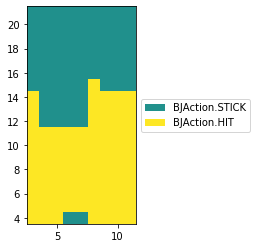

In [69]:
%matplotlib inline
img = np.ones((22, 12)) * -1
probs = np.zeros((22, 12))

usable_ace = False

for (state, action), prob in target_policy.items():
    if state.player.usable_ace != usable_ace:
        continue
    if prob < probs[state.player.value, state.dealer.value]:
        continue
    probs[state.player.value, state.dealer.value] = prob
    img[state.player.value, state.dealer.value] = int(action)

# rotate ace to have low rather than high value to match book
ace = img[:, -1]
img[:, 1:] = img[:, :-1]
img[:, 3] = ace

# plot image and clip to match book
pos = plt.imshow(img, origin="lower")
plt.xlim(2.5)
plt.ylim(3.5)

# create legend with colors for each action
legend_elements = [
    Patch(facecolor=pos.cmap.colors[len(pos.cmap.colors) // 2], label=BJAction(0)),
    Patch(facecolor=pos.cmap.colors[-1], label=BJAction(1))
]
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), handles=legend_elements)

plt.show()

---